In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from nltk.tokenize import sent_tokenize
import time
import pandas as pd
import torch
import seaborn as sns
import spacy
from pathlib import Path
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import random
import nltk
nltk.download('punkt')


In [ ]:
# prepare text using the both the nltk sentence tokenizer (https://www.nltk.org/api/nltk.tokenize.html)
# AND the spacy english pipeline (see https://spacy.io/models/en)


def prepare_texts(text, min_frequency=3):
    
    # Get a callable object from spacy that processes the text - lemmatizes and determines part of speech

    nlp = spacy.load("en_core_web_sm")
    
    # Some text cleaning. Do it by sentence, and eliminate punctuation.
    lemmas = []
    for sent in sent_tokenize(text):  # sent_tokenize separates the sentences 
        for tok in nlp(sent):         # nlp processes as in Part III
            if tok.pos_ not in ["PUNCT", "SPACE", "SYM", "NUM", "X"] and tok.lemma_ not in "[]|.,/?'\"+-=":
                lemmas.append(tok.lemma_)
    
    # Count the frequency of each lemmatized word
    freqs = Counter()  # word -> occurrence
    for w in lemmas:
        freqs[w] += 1
        
    vocab = list(freqs.items())  # List of (word, occurrence)
    vocab = sorted(vocab, key=lambda item: item[1], reverse=True)  # Sort by decreasing frequency
    
    # per Mikolov, don't use the infrequent words, as there isn't much to learn in that case
    
    frequent_vocab = list(filter(lambda item: item[1]>=min_frequency, vocab))
    
    # Create the dictionaries to go from word to index or vice-verse
    
    w2i = {w[0]:i for i,w in enumerate(frequent_vocab)}
    i2w = {i:w[0] for i,w in enumerate(frequent_vocab)}
    
    # Create an Out Of Vocabulary (oov) token as well
    w2i["<oov>"] = len(frequent_vocab)
    i2w[len(frequent_vocab)] = "<oov>"
    
    # Set all of the words not included in vocabulary nuas oov
    filtered_lemmas = []
    for lem in lemmas:
        if lem not in w2i:
            filtered_lemmas.append("<oov>")
        else:
            filtered_lemmas.append(lem)
    
    return filtered_lemmas, w2i, i2w, frequent_vocab

In [ ]:
fileObject = open("LargerCorpus.txt", "r")
data = fileObject.read()
print(data)

In [ ]:
lemmas, w2i, i2w, frequent_vocab = prepare_texts(data)

In [ ]:
print(len(lemmas))
print(len(w2i))

62015
2560


In [ ]:
frequent_vocab[0:20]

[('the', 5047),
 ('of', 3438),
 ('be', 2283),
 ('and', 1943),
 ('in', 1588),
 ('to', 1379),
 ('a', 1226),
 ('for', 531),
 ('as', 518),
 ('by', 493),
 ('he', 483),
 ('with', 471),
 ('coin', 417),
 ('this', 387),
 ('on', 377),
 ('his', 368),
 ('which', 346),
 ('at', 334),
 ('it', 332),
 ('from', 326)]

### tokenize_and_preprocess_text creates the training samples for the model. It walks through each word in the corpus, and looks at a window (of size 'window') of words and creates input/output prediction pairs.  We need both positive (in window) samples and negative (out of window) samples.

In [ ]:
def tokenize_and_preprocess_text(textlist, w2i, window):
    """
    Skip-gram negative sampling: Predict if the target word is in the context.
    Uses binary prediction so we need both positive and negative samples
    """
    X, T, Y = [], [], []
    nlp = spacy.load("en_core_web_sm")

    for sent in sent_tokenize(textlist):  # sent_tokenize separates the sentences 
      temp = []
      for tok in nlp(sent):         # nlp processes as in Part III
          if tok.pos_ not in ["PUNCT", "SPACE", "SYM", "NUM", "X"] and tok.lemma_ not in "[]|.,/?'\"+-=":
            temp.append(tok.lemma_)

      lemma_idx = [w2i[word] if word in w2i else w2i["<oov>"] for word in temp]

      for idx in range(len(lemma_idx)):
          window1 = max(idx - (window-1)//2, 0)
          window2 = min(idx + (window-1)//2, len(lemma_idx)-1)

          while window1 <= window2:
            if window1 == idx:
              window1+=1
              continue
            X.append(lemma_idx[idx])
            T.append(lemma_idx[window1])
            Y.append(1.0)
            X.append(lemma_idx[idx])
            T.append(random.choice(list(w2i.values())))
            Y.append(0.0)

            window1 += 1
    return X, T, Y

In [ ]:
X, T, Y = tokenize_and_preprocess_text(data, w2i, window=5)

In [ ]:
print(X[0:10])
print(T[0:10])
print(Y[0:10])

[78, 78, 78, 78, 1, 1, 1, 1, 1, 1]
[1, 974, 0, 590, 78, 2029, 0, 396, 772, 2405]
[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]


## Define Model that will be trained to produce word vectors

In [ ]:
class SkipGramNegativeSampling(torch.nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        
        self.embedding_x = torch.nn.Embedding(vocab_size, embedding_size)
        self.embedding_t = torch.nn.Embedding(vocab_size, embedding_size)
        self.fc = torch.nn.Linear(embedding_size, 1)

    def forward(self, x, t):
        
        embed_x = self.embedding_x(x)
        embed_t = self.embedding_t(t)
        out = torch.mul(embed_x, embed_t)
        out = self.fc(out)
        prediction = torch.sigmoid(out).squeeze()
        return prediction

#### The training function - give it the text and it does the rest

In [ ]:
def data_unzip(data):
  unzipped_object = zip(*data)
  unzipped_list = list(unzipped_object)
  return unzipped_list[0], unzipped_list[1]

def train_sgns(textlist, window, embedding_size):
    # Set up a model with Skip-gram with negative sampling (predict context with word)
    # textlist: a list of strings
    global w2i, i2w
    X, T, Y = tokenize_and_preprocess_text(textlist, w2i, window)
    num_epoch = 30
    learning_rate = 3e-4
    batch_size = 4
    # Create Training Data
    X_T_train, X_T_test, y_train, y_test = train_test_split(list(zip(X, T)), Y, test_size=0.2, shuffle=True, random_state=24)
    X_train, T_train = data_unzip(X_T_train)
    X_test, T_test = data_unzip(X_T_test)
    X_train_batch = torch.tensor(X_train).split(batch_size)
    T_train_batch = torch.tensor(T_train).split(batch_size)
    y_train_batch = torch.tensor(y_train).split(batch_size)

    X_test = torch.tensor(X_test)
    T_test = torch.tensor(T_test)
    y_test = torch.tensor(y_test)


    # instantiate the network & set up the optimizer
    network = SkipGramNegativeSampling(vocab_size=len(w2i), embedding_size=embedding_size)

    epoches, train_loss, val_loss = [], [], []
    optimizer = torch.optim.Adam(network.parameters(), lr =learning_rate)
    loss_func = torch.nn.BCELoss()

    for epoch in range(num_epoch):
      total_train_loss = 0
      total_val_loss = 0

      for x, t, target in zip(X_train_batch, T_train_batch, y_train_batch):
        prediction = network(x, t)
        # if prediction.shape==torch.Size([]):
        #   prediction = prediction.unsqueeze(0)
        loss = loss_func(prediction.squeeze(), target.squeeze())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_train_loss+=loss.item()
      
      epoches.append(epoch+1)
      total_train_loss/=len(X_train_batch)
      train_loss.append(total_train_loss)

      ### Validation loss

      prediction_val = network(X_test, T_test)
      total_val_loss = loss_func(prediction_val.squeeze(), y_test.squeeze()).item()
      val_loss.append(total_val_loss)
      
      print("----This is epoch {} with training loss {} and validation loss {}----".format(epoch+1, total_train_loss, total_val_loss))

    plt.title("Training Curve")
    plt.plot(epoches, train_loss, label="Train")
    plt.plot(epoches, val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.legend(loc='best')
    plt.show()

    return network

### Run Training and retrieve embedding

----This is epoch 1 with training loss 0.6704032872791653 and validation loss 0.6273868680000305----
----This is epoch 2 with training loss 0.5751466939215178 and validation loss 0.5397635102272034----
----This is epoch 3 with training loss 0.5013976665773923 and validation loss 0.48799946904182434----
----This is epoch 4 with training loss 0.46061202232658405 and validation loss 0.4601372480392456----
----This is epoch 5 with training loss 0.4385358410441447 and validation loss 0.44473254680633545----
----This is epoch 6 with training loss 0.4260308899437451 and validation loss 0.4357747733592987----
----This is epoch 7 with training loss 0.41853321070095445 and validation loss 0.43030083179473877----
----This is epoch 8 with training loss 0.4137949796682666 and validation loss 0.4267953336238861----
----This is epoch 9 with training loss 0.4106570398012536 and validation loss 0.4244464039802551----
----This is epoch 10 with training loss 0.4084948640368379 and validation loss 0.42280

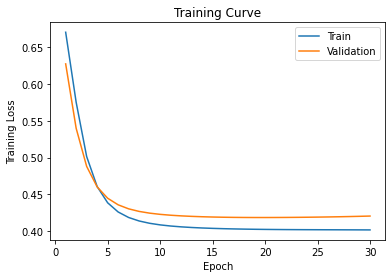

In [ ]:
# Run the training loop
network = train_sgns(data, window=5, embedding_size=8)
embedding = network.embedding_t

### Reduce the Dimensionality of Embeddings and Display

Visualizing the 20 to 65 most frequent words


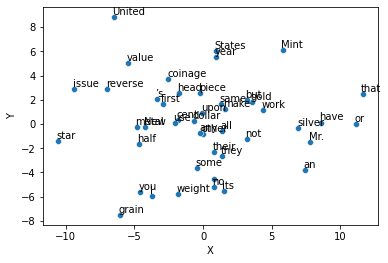

In [ ]:
from sklearn.decomposition import PCA #see https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

def visualize_embedding(embedding, most_frequent_from=20, most_frequent_to=80):
    print ("Visualizing the {} to {} most frequent words".format(most_frequent_from, most_frequent_to))
    
    # since the embeddings are ordered from most frequent words to least frequent, 
    # we can easily select a sub range of the most frequent words:
    
    selected_words = embedding[most_frequent_from:most_frequent_to, :]
    
    # The function below will reduce a vector to 2 principle components
    
    pca = PCA(n_components=2)
    
    # Transform the selected embeddings to have 2 dimensions
    
    embeddings = pca.fit_transform(selected_words)
    
    # Plot the the reduced embeddings - a point and the word itself
    df = pd.DataFrame(embeddings, columns=["X", "Y"])
    df['word'] = list(w2i.keys())[most_frequent_from:most_frequent_to]
    sns.scatterplot(data=df, x='X', y='Y')
    for i in range(df.shape[0]):
      plt.text(x=df.X[i]-0.1,y=df.Y[i]+0.2,s=df.word[i], fontdict=dict(color='black', size=10))
    plt.show()
    
visualize_embedding(embedding.weight.data.detach().numpy(), most_frequent_from=20, most_frequent_to=65)